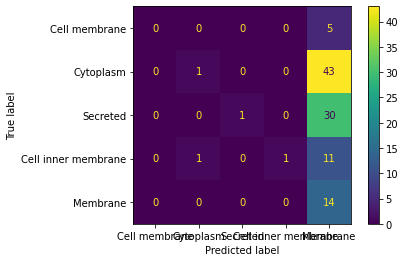

In [167]:
import requests
import pandas as pd
import numpy as np
import io
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle



# Request URL for the dataset chosen: All Uniprot entries for the Mycobacterium tuberculosis (strain ATCC 25618 / H37Rv). This URL downloads a tsv database with the entry,
# and the sequence, sequence length and subcellular location of each entry.

def import_request_tsv(url = "https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Csequence%2Clength%2Ccc_subcellular_location&compressed=false&format=tsv&query=((organism_id:83332))", filename = "83332.tsv"):
    # Request to save the content on the above URL page.
    all_data = requests.get(url).content
    # Reads the tsv table in as a pandas dataframe.
    df = pd.read_csv(io.StringIO(all_data.decode('utf-8')), sep = "\t")
    # Create a local file with the information of the database in case Uniprot does not respond to requests.
    df.to_csv(filename,  sep="\t") 
    return df

# Cleaning the data such that each entry has one subcellular location: this selects for the first non-braketed entry in the "Subcellular location [CC]" column of the
# dataframe.

def cleaningdf(df):
    # Removes all entries for which the subcellular location is unknown, as all other cells contain data.
    df = df.dropna()
    # Splits the strings by a lot of punctuation marks.
    ilist = []
    olist = []
    for i in df["Subcellular location [CC]"]:
        ilist.append(i)
        j = i.replace("SUBCELLULAR LOCATION: ", "")
        k = j.split(" {")
        l = k[0].split(".")
        m = l[0].split(",")
        n = m[0].split(": ")
        # Removes one entry where the first subcellular location was in a format that could not be generalised otherwise. If no such entry exists in another dataset, this is 
        # not done.
        if len(n) == 2:
            f = n
            n = []
            n.append(f[1])
        o = n[0].split(";")
        olist.append(o[0])
        # Replaces the "Subcellular location [CC]" column with the cleaned version in a new dataframe.
        df = df.replace(ilist, olist)
    return df

# Removes all entries from the dataframe that have a sequence length less than the sequence limit, and a subcellular location that occurs in fewer entries than the count limit.

def seqcountlimiter(df, count_limit, sequence_limit):
    counts = df["Subcellular location [CC]"].value_counts()
    largecount = counts[counts > count_limit].index
    seqlengths = df["Length"]
    largeseq = seqlengths[seqlengths > sequence_limit].index
    df = df[df["Subcellular location [CC]"].isin(largecount)]
    df = df[df["Length"].isin(largeseq)]
    return df

# Splits the sequences of the dataframe into all possible character strings of length ngram_size, creates an array of the presence of each ngram in each sequence, and 
# returns the array and the list of target subcellular locations.
def ngram_dataframe_maker(df, ngram_size):
    ngram_vectorizer = CountVectorizer(analyzer = 'char', ngram_range = (ngram_size, ngram_size))
    seqlist = []
    for i in df["Sequence"]:
        seqlist.append(i)
    ngram_count = ngram_vectorizer.fit_transform(seqlist)
    ngram_list = ngram_vectorizer.get_feature_names()
    array = ngram_count.toarray().astype(int)
    dfarray = pd.DataFrame(array, columns = ngram_list)
    target_location = []
    for i in df["Subcellular location [CC]"]:
        target_location.append(i)
    le = preprocessing.LabelEncoder()
    le.fit(target_location)
    arraytarget = le.transform(target_location)
    dfarray["Target Location"] = arraytarget
    return dfarray, target_location

# Splits the dataset into a set for training a classifier and a set for testing the trained classifier.
def splitting(df, test_size = 0.2, random_state = 2):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df.iloc[:, [-1]], test_size = test_size, random_state = random_state)
    # Ensures the output targets are one-dimensional arrays and correctly labelled.
    y_train = y_train["Target Location"]
    y_test = y_test["Target Location"]
    return X_train, X_test, y_train, y_test

# Trains a classifier on a training set of data.
def classifiertrain(X_train, y_train):
    # Some examples are not exhaustively trained after 800 iterations, but are sufficiently powerful to produce an AUC above 0.8. Random_state = 2 was chosen as 
    # random_state = 1 gave an AUC of 0.7992 for one example.
    clf = MLPClassifier(random_state = 2, max_iter = 800)
    fit = clf.fit(X_train, y_train)
    return fit

# Tests a trained classifier on the testing set and returns the predicted target values.
def classifiertestpred(fit, X_test):
    y_pred = fit.predict_proba(X_test)
    y_return = fit.predict(X_test)
    return y_pred, y_return

# This step takes a long time: see README.md.
#df = cleaningdf(df)

# Pipeline for the document post-cleaning, does not include plots.
def dfpipelinetoout(df):
    df = seqcountlimiter(df, 50, 50)
    ngram_df = ngram_dataframe_maker(df, 10)
    split_data_groups = splitting(ngram_df[0])
    classifier = classifiertrain(split_data_groups[0], split_data_groups[2])
    y_probscore, y_firmscore = classifiertestpred(classifier, split_data_groups[1])
    y_test = split_data_groups[3]
    dfarray = ngram_df[0]
    target_list = ngram_df[1]
    y_train = split_data_groups[2]
    return y_probscore, y_firmscore, y_test, dfarray, target_list, y_train

# Calculates the roc score for all probable predicted/result pairs, based upon their prevalence in the test set.
def rocscoremulti(y_test, y_probscore):
    rocscore = metrics.roc_auc_score(y_test, y_probscore, average = "weighted", multi_class = "ovr", labels = None)
    return rocscore

# Calculates and produces a matrix based on the determined predictions and their contrast with the actual results according to the test set.
def confusionmatrix(y_test, y_firmscore, target_location):
    target_list = []
    cm = confusion_matrix(y_test, y_firmscore)
    for i in target_location:
        if i not in target_list:
            target_list.append(i)
    cm = ConfusionMatrixDisplay(cm, display_labels = target_list)
    cm.plot()
    return

#a = dfpipelinetoout(df) 
rocscoremulti(a[2], a[0])
confusionmatrix(a[2], a[1], a[4])



In [ ]:
# THE BELOW DOES NOT WORK. I SPENT AGES TRYING TO GET IT TO WORK, BUT IT DOESN'T. I CAN'T GET MULTICLASS ROC CURVES. Please take into account that REST API was a stretch goal and that I did at least get a confusion matrix of my results.

label_binarizer = LabelBinarizer().fit(a[4])
v = label_binarizer.transform(a[1])
y_onehot_test.shape  # (n_samples, n_classes


RocCurveDisplay(v, a[1])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()